In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# 1. 输入实验数据
t_exp = np.array([0, 5, 10, 15, 20, 30])  # 时间t（min）
qt_exp = np.array([0, -0.025, 0.025, 0.1, 0.125, 0.675])  # 吸附量qₜ（mg/g）

# 2. 定义准二级动力模型
def pseudo_second_order(t, qe, k2):
    return (qe ** 2 * k2 * t) / (1 + qe * k2 * t)

# 3. 拟合参数（设置合理的初始猜测p0）
# 准二级模型中qe通常与吸附饱和容量相关，k2是速率常数，可根据数据趋势调整p0
params_opt, _ = curve_fit(
    pseudo_second_order, 
    t_exp, 
    qt_exp, 
    p0=[1.0, 0.01]  # 初始猜测：qe=1.0 mg/g，k2=0.01 g/(mg·min)，可根据需要调整
)
qe_opt, k2_opt = params_opt

# 4. 计算理论拟合值与R²
t_fit = np.linspace(t_exp.min(), t_exp.max(), 100)  # 平滑时间序列
qt_fit = pseudo_second_order(t_fit, qe_opt, k2_opt)  # 理论拟合值
r2 = r2_score(qt_exp, pseudo_second_order(t_exp, qe_opt, k2_opt))  # 决定系数R²

# 5. 绘制拟合结果图
plt.rcParams['font.sans-serif'] = ['Arial']  # 统一字体
plt.figure(figsize=(8, 5))

# 绘制实验数据点（红色散点）
plt.scatter(t_exp, qt_exp, color='red', s=60, label='Experimental Data', zorder=5)
# 绘制拟合曲线（蓝色实线）
plt.plot(t_fit, qt_fit, color='blue', linewidth=2, 
         label=f'Fitting Curve\nqe={qe_opt:.3f} mg/g, k2={k2_opt:.3f} g/(mg·min), R²={r2:.3f}')

# 坐标轴设置
plt.xlabel('Time (min)', fontsize=12)
plt.ylabel('Adsorption Capacity qₜ (mg/g)', fontsize=12)
plt.ylim(-0.05, 0.9)  # 纵轴范围适配数据
plt.xlim(-1, 32)  # 横轴留白更美观

# 图例与网格
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)

# 保存与显示图片
plt.savefig('pseudo_second_order_fitting.png', dpi=300, bbox_inches='tight')
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/3847720963.py:63: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


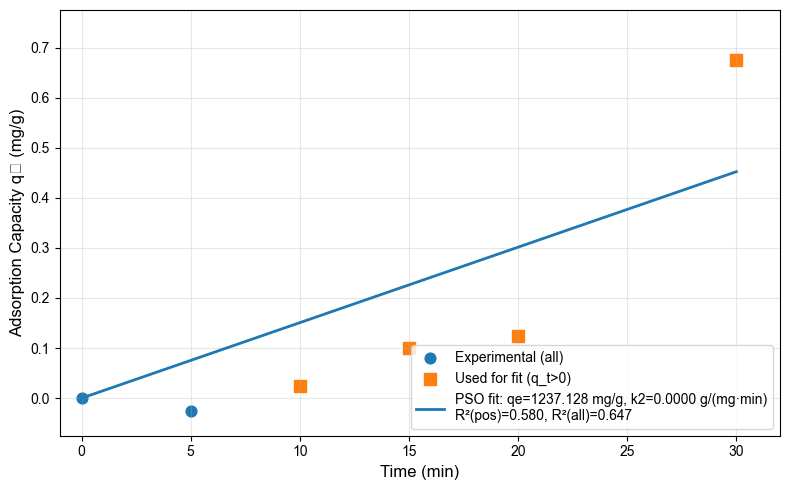

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# 1) 数据
t_exp = np.array([0, 5, 10, 15, 20, 30], dtype=float)
qt_exp = np.array([0, -0.025, 0.025, 0.1, 0.125, 0.675], dtype=float)

# 2) 准二级模型（PFO2）
def pseudo_second_order(t, qe, k2):
    return (qe**2 * k2 * t) / (1.0 + qe * k2 * t)

# 3) 仅使用 q_t>0 的点拟合
mask_pos = qt_exp > 0
t_fit_data = t_exp[mask_pos]
qt_fit_data = qt_exp[mask_pos]

# 4) 合理初值（从数据估计）
qe0 = qt_exp.max() + 0.05   # 比最大观测值略大
# 估计首个正点的近似斜率（用前后差分保守估一下）
idx_first_pos = np.where(mask_pos)[0][0]
if idx_first_pos == 0:
    slope0 = qt_exp[1] / (t_exp[1] + 1e-9)
else:
    slope0 = (qt_exp[idx_first_pos] - qt_exp[idx_first_pos-1]) / (t_exp[idx_first_pos] - t_exp[idx_first_pos-1] + 1e-9)
k20 = max(slope0 / (qe0**2), 1e-6)  # 防止非正或过小

# 5) 约束 + 更高的迭代上限
bounds = (0, np.inf)
popt, pcov = curve_fit(
    pseudo_second_order,
    t_fit_data, qt_fit_data,
    p0=[qe0, k20],
    bounds=bounds,
    maxfev=20000
)
qe_opt, k2_opt = popt

# 6) 计算预测与 R²
qt_pred_all = pseudo_second_order(t_exp, qe_opt, k2_opt)
qt_pred_pos = pseudo_second_order(t_fit_data, qe_opt, k2_opt)
r2_all = r2_score(qt_exp, qt_pred_all)            # 包含负值点（会偏低）
r2_pos = r2_score(qt_fit_data, qt_pred_pos)       # 仅对参与拟合的点

# 7) 画图（不强制指定颜色，避免样式干扰）
t_smooth = np.linspace(t_exp.min(), t_exp.max(), 200)
qt_smooth = pseudo_second_order(t_smooth, qe_opt, k2_opt)

plt.figure(figsize=(8,5))
plt.scatter(t_exp, qt_exp, s=60, label='Experimental (all)')
plt.scatter(t_fit_data, qt_fit_data, s=80, marker='s', label='Used for fit (q_t>0)')
plt.plot(t_smooth, qt_smooth, linewidth=2,
         label=f'PSO fit: qe={qe_opt:.3f} mg/g, k2={k2_opt:.4f} g/(mg·min)\n'
               f'R²(pos)={r2_pos:.3f}, R²(all)={r2_all:.3f}')

plt.xlabel('Time (min)', fontsize=12)
plt.ylabel('Adsorption Capacity qₜ (mg/g)', fontsize=12)
plt.xlim(t_exp.min()-1, t_exp.max()+2)
plt.ylim(min(qt_exp.min(), 0)-0.05, max(qt_exp.max(), 0)+0.1)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()


原始数据:
t = 0, qt = 0.0
t = 5, qt = -0.025
t = 10, qt = 0.025
t = 15, qt = 0.1
t = 20, qt = 0.125
t = 30, qt = 0.675

拟合结果:
平衡吸附量 qe = 3478.790676 ± 25946360.456444
速率常数 k1 = 0.000004 ± 0.031675
决定系数 R² = 0.647710

拟合数据对比:
t =  0: 实验值 =  0.000, 拟合值 =  0.000, 残差 =  0.000
t =  5: 实验值 = -0.025, 拟合值 =  0.074, 残差 = -0.099
t = 10: 实验值 =  0.025, 拟合值 =  0.148, 残差 = -0.123
t = 15: 实验值 =  0.100, 拟合值 =  0.222, 残差 = -0.122
t = 20: 实验值 =  0.125, 拟合值 =  0.295, 残差 = -0.170
t = 30: 实验值 =  0.675, 拟合值 =  0.443, 残差 =  0.232


/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/447231491.py:135: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/447231491.py:135: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/447231491.py:135: UserWarning: Glyph 21560 (\N{CJK UNIFIED IDEOGRAPH-5438}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/447231491.py:135: UserWarning: Glyph 38468 (\N{CJK UNIFIED IDEOGRAPH-9644}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/447231491.py:135: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/i

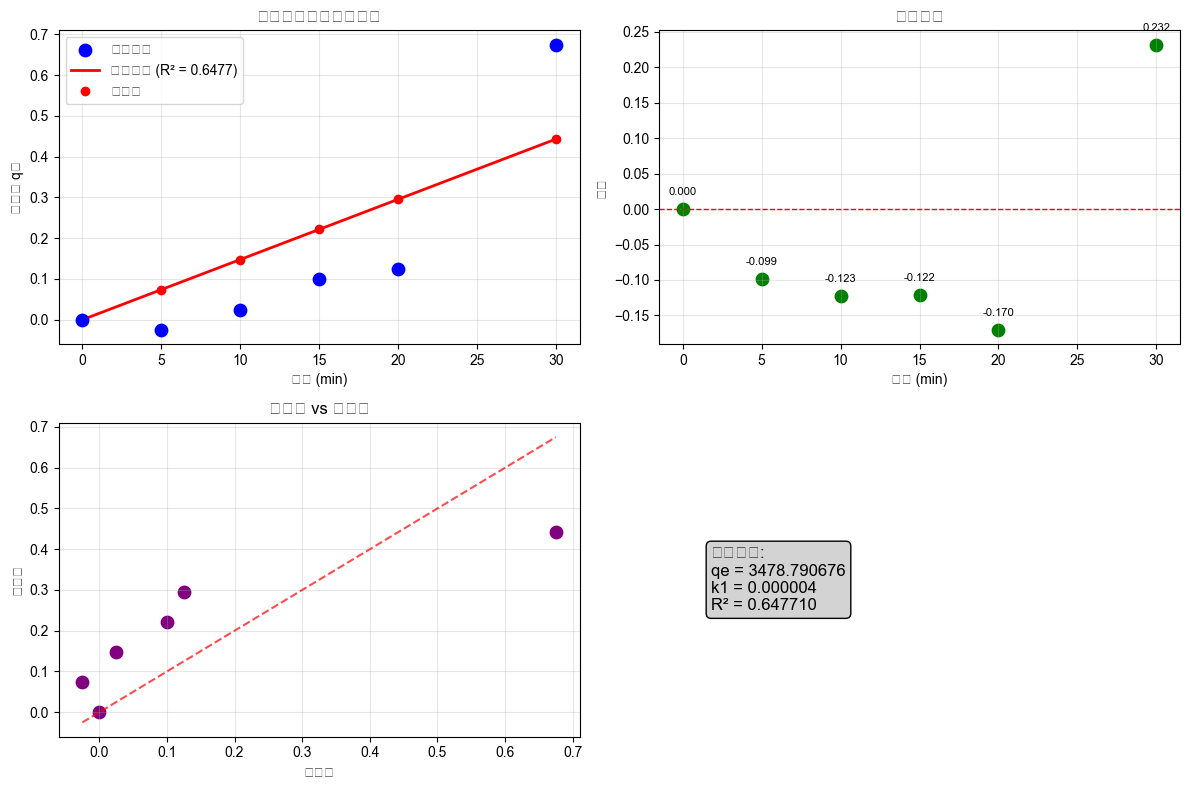


数据质量分析:
数据点数量: 6
qt 数据范围: -0.025 到 0.675
数据变异性: 0.240659
警告: 数据中包含 1 个负值
建议: 负值可能是测量误差，考虑将其设为0或重新测量

模型预测:
t = 40 min: 预测 qt = 0.590880
t = 50 min: 预测 qt = 0.738584
t = 60 min: 预测 qt = 0.886282
达到95%平衡吸附量的时间: 705432.32 min


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 准一级动力学模型函数
def pseudo_first_order(t, qe, k1):
    return qe * (1 - np.exp(-k1 * t))

# 您的实验数据
t_data = np.array([0, 5, 10, 15, 20, 30])
qt_data = np.array([0, -0.025, 0.025, 0.1, 0.125, 0.675])

print("原始数据:")
for i in range(len(t_data)):
    print(f"t = {t_data[i]}, qt = {qt_data[i]}")

# 非线性拟合
try:
    # 使用合理的初始猜测值
    initial_guess = [0.7, 0.1]  # [qe, k1]
    
    popt, pcov = curve_fit(pseudo_first_order, t_data, qt_data, 
                          p0=initial_guess, maxfev=5000)
    
    qe_fit, k1_fit = popt
    qe_error, k1_error = np.sqrt(np.diag(pcov))
    
    # 计算拟合值
    qt_fit = pseudo_first_order(t_data, qe_fit, k1_fit)
    
    # 计算R²
    ss_res = np.sum((qt_data - qt_fit) ** 2)
    ss_tot = np.sum((qt_data - np.mean(qt_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    print("\n拟合结果:")
    print(f"平衡吸附量 qe = {qe_fit:.6f} ± {qe_error:.6f}")
    print(f"速率常数 k1 = {k1_fit:.6f} ± {k1_error:.6f}")
    print(f"决定系数 R² = {r_squared:.6f}")
    
    # 输出拟合数据点
    print("\n拟合数据对比:")
    for i in range(len(t_data)):
        print(f"t = {t_data[i]:2d}: 实验值 = {qt_data[i]:6.3f}, 拟合值 = {qt_fit[i]:6.3f}, 残差 = {qt_data[i]-qt_fit[i]:6.3f}")
    
except Exception as e:
    print(f"拟合过程中出现错误: {e}")
    # 如果拟合失败，尝试手动优化参数
    print("尝试手动优化参数...")
    
    # 手动尝试几组参数
    test_params = [
        [0.7, 0.1],
        [0.8, 0.08],
        [0.6, 0.12]
    ]
    
    best_r2 = -np.inf
    best_params = None
    
    for params in test_params:
        qe_test, k1_test = params
        qt_test = pseudo_first_order(t_data, qe_test, k1_test)
        r2_test = 1 - (np.sum((qt_data - qt_test) ** 2) / np.sum((qt_data - np.mean(qt_data)) ** 2))
        
        print(f"测试参数: qe={qe_test:.3f}, k1={k1_test:.3f}, R²={r2_test:.6f}")
        
        if r2_test > best_r2:
            best_r2 = r2_test
            best_params = params
    
    if best_params:
        qe_fit, k1_fit = best_params
        qt_fit = pseudo_first_order(t_data, qe_fit, k1_fit)
        print(f"\n最佳手动参数: qe={qe_fit:.6f}, k1={k1_fit:.6f}, R²={best_r2:.6f}")

# 绘制结果
plt.figure(figsize=(12, 8))

# 主图
plt.subplot(2, 2, 1)
plt.scatter(t_data, qt_data, color='blue', label='实验数据', s=80, zorder=5)
if 'qt_fit' in locals():
    # 绘制平滑拟合曲线
    t_smooth = np.linspace(0, max(t_data), 100)
    qt_smooth = pseudo_first_order(t_smooth, qe_fit, k1_fit)
    plt.plot(t_smooth, qt_smooth, 'r-', label=f'拟合曲线 (R² = {r_squared:.4f})', linewidth=2)
    
    # 绘制拟合数据点
    plt.plot(t_data, qt_fit, 'ro', markersize=6, label='拟合点')
    
plt.xlabel('时间 (min)')
plt.ylabel('吸附量 qₜ')
plt.title('准一级动力学模型拟合')
plt.legend()
plt.grid(True, alpha=0.3)

# 残差图
plt.subplot(2, 2, 2)
if 'qt_fit' in locals():
    residuals = qt_data - qt_fit
    plt.scatter(t_data, residuals, color='green', s=80)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('时间 (min)')
    plt.ylabel('残差')
    plt.title('残差分析')
    plt.grid(True, alpha=0.3)
    
    # 在残差图上标注数值
    for i, (t, res) in enumerate(zip(t_data, residuals)):
        plt.annotate(f'{res:.3f}', (t, res), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=8)

# 拟合值与实验值对比
plt.subplot(2, 2, 3)
if 'qt_fit' in locals():
    plt.scatter(qt_data, qt_fit, color='purple', s=80)
    # 绘制对角线
    min_val = min(min(qt_data), min(qt_fit))
    max_val = max(max(qt_data), max(qt_fit))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
    plt.xlabel('实验值')
    plt.ylabel('拟合值')
    plt.title('拟合值 vs 实验值')
    plt.grid(True, alpha=0.3)

# 参数显示
plt.subplot(2, 2, 4)
if 'qe_fit' in locals() and 'k1_fit' in locals():
    plt.axis('off')
    text_str = f'拟合参数:\nqe = {qe_fit:.6f}\nk1 = {k1_fit:.6f}\nR² = {r_squared:.6f}'
    plt.text(0.1, 0.5, text_str, fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.tight_layout()
plt.show()

# 数据质量分析
print("\n数据质量分析:")
print(f"数据点数量: {len(t_data)}")
print(f"qt 数据范围: {min(qt_data):.3f} 到 {max(qt_data):.3f}")
print(f"数据变异性: {np.std(qt_data):.6f}")

# 检查负值问题
negative_points = qt_data[qt_data < 0]
if len(negative_points) > 0:
    print(f"警告: 数据中包含 {len(negative_points)} 个负值")
    print("建议: 负值可能是测量误差，考虑将其设为0或重新测量")

# 模型预测
print("\n模型预测:")
future_times = [40, 50, 60]
if 'qe_fit' in locals() and 'k1_fit' in locals():
    for t in future_times:
        predicted_qt = pseudo_first_order(t, qe_fit, k1_fit)
        print(f"t = {t} min: 预测 qt = {predicted_qt:.6f}")
    
    # 计算达到平衡的时间（达到95%平衡吸附量）
    t_95 = -np.log(0.05) / k1_fit
    print(f"达到95%平衡吸附量的时间: {t_95:.2f} min")

原始数据:
t = 0, qt = 0.0
t = 10, qt = 0.025
t = 15, qt = 0.1
t = 20, qt = 0.125
t = 30, qt = 0.675

线性化数据 (t/qt):
t = 10, t/qt = 400.000
t = 15, t/qt = 150.000
t = 20, t/qt = 160.000
t = 30, t/qt = 44.444

线性回归结果:
斜率 (1/qe) = -15.371429
截距 = 476.825397
相关系数 R = -0.873256
决定系数 R² = 0.762576
标准误差 = 6.064845

准二级动力学参数:
平衡吸附量 qe = -0.065056
准二级速率常数 k2 = 0.495529


/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/2963973709.py:141: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/2963973709.py:141: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/2963973709.py:141: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/2963973709.py:141: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_17353/2963973709.py:141: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000g

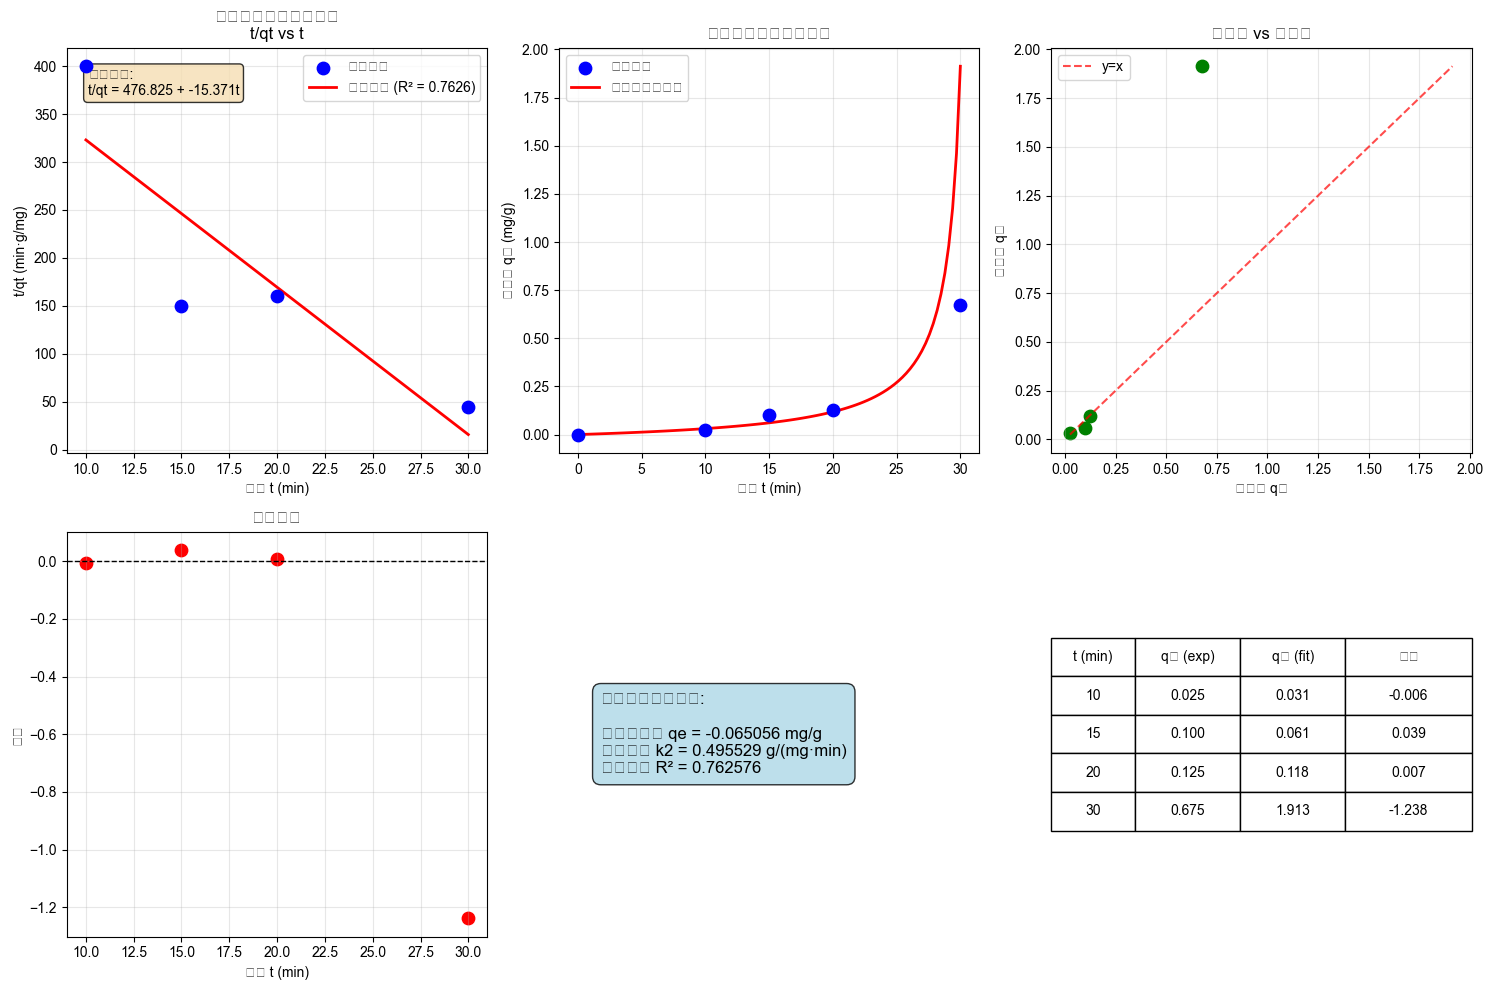


模型验证:
初始吸附速率 h = k2 × qe² = 0.002097 mg/(g·min)

模型预测:
t =  40 min: 预测 qₜ = -0.289788 mg/g
t =  50 min: 预测 qₜ = -0.171382 mg/g
t =  60 min: 预测 qₜ = -0.134692 mg/g
t =  90 min: 预测 qₜ = -0.099272 mg/g
t = 120 min: 预测 qₜ = -0.087736 mg/g

达到不同平衡程度所需时间:
达到 50% 平衡: t = -31.02 min
达到 90% 平衡: t = -279.18 min
达到 95% 平衡: t = -589.38 min
达到 99% 平衡: t = -3071.00 min

数据质量评估:
数据点数量: 4
qₜ 数据范围: 0.025 到 0.675
线性相关系数: -0.873256
拟合优度: 较差 (R² ≤ 0.80)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 准二级动力学模型线性形式
def pseudo_second_order_linear(t, qt):
    """
    准二级动力学线性形式: t/qt vs t
    线性方程: t/qt = 1/(k2 * qe²) + (1/qe) * t
    """
    return t / qt

# 您的实验数据
t_data = np.array([0, 10, 15, 20, 30])
qt_data = np.array([0, 0.025, 0.1, 0.125, 0.675])

print("原始数据:")
for i in range(len(t_data)):
    print(f"t = {t_data[i]}, qt = {qt_data[i]}")

# 排除t=0的点（因为t/qt会无穷大）
t_linear = t_data[1:]
qt_linear = qt_data[1:]

# 计算线性形式: t/qt
t_over_qt = t_linear / qt_linear

print("\n线性化数据 (t/qt):")
for i in range(len(t_linear)):
    print(f"t = {t_linear[i]}, t/qt = {t_over_qt[i]:.3f}")

# 线性回归
slope, intercept, r_value, p_value, std_err = stats.linregress(t_linear, t_over_qt)

# 计算准二级动力学参数
# 从线性方程: t/qt = 1/(k2 * qe²) + (1/qe) * t
# 斜率 = 1/qe, 截距 = 1/(k2 * qe²)
qe_calculated = 1 / slope
k2_calculated = 1 / (intercept * qe_calculated ** 2)

print(f"\n线性回归结果:")
print(f"斜率 (1/qe) = {slope:.6f}")
print(f"截距 = {intercept:.6f}")
print(f"相关系数 R = {r_value:.6f}")
print(f"决定系数 R² = {r_value**2:.6f}")
print(f"标准误差 = {std_err:.6f}")

print(f"\n准二级动力学参数:")
print(f"平衡吸附量 qe = {qe_calculated:.6f}")
print(f"准二级速率常数 k2 = {k2_calculated:.6f}")

# 计算拟合的t/qt值
t_over_qt_fit = intercept + slope * t_linear

# 计算拟合的qt值（从线性形式反推）
qt_fit_linear = t_linear / t_over_qt_fit

# 使用参数计算完整模型的拟合值
def pseudo_second_order(t, qe, k2):
    """准二级动力学完整模型"""
    return (k2 * qe**2 * t) / (1 + k2 * qe * t)

# 使用线性拟合得到的参数计算拟合曲线
t_smooth = np.linspace(0, max(t_data), 100)
qt_smooth = pseudo_second_order(t_smooth, qe_calculated, k2_calculated)

# 绘图
plt.figure(figsize=(15, 10))

# 子图1: 线性拟合图 (t/qt vs t)
plt.subplot(2, 3, 1)
plt.scatter(t_linear, t_over_qt, color='blue', s=80, label='实验数据', zorder=5)
plt.plot(t_linear, t_over_qt_fit, 'r-', label=f'线性拟合 (R² = {r_value**2:.4f})', linewidth=2)
plt.xlabel('时间 t (min)')
plt.ylabel('t/qt (min·g/mg)')
plt.title('准二级动力学线性拟合\nt/qt vs t')
plt.legend()
plt.grid(True, alpha=0.3)

# 添加线性方程标注
equation_text = f'线性方程:\nt/qt = {intercept:.3f} + {slope:.3f}t'
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 子图2: 完整模型拟合
plt.subplot(2, 3, 2)
plt.scatter(t_data, qt_data, color='blue', s=80, label='实验数据', zorder=5)
plt.plot(t_smooth, qt_smooth, 'r-', label='准二级模型拟合', linewidth=2)
plt.xlabel('时间 t (min)')
plt.ylabel('吸附量 qₜ (mg/g)')
plt.title('准二级动力学模型拟合')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图3: 拟合值与实验值对比
plt.subplot(2, 3, 3)
plt.scatter(qt_linear, qt_fit_linear, color='green', s=80)
min_val = min(min(qt_linear), min(qt_fit_linear))
max_val = max(max(qt_linear), max(qt_fit_linear))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='y=x')
plt.xlabel('实验值 qₜ')
plt.ylabel('拟合值 qₜ')
plt.title('拟合值 vs 实验值')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图4: 残差分析
plt.subplot(2, 3, 4)
residuals = qt_linear - qt_fit_linear
plt.scatter(t_linear, residuals, color='red', s=80)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('时间 t (min)')
plt.ylabel('残差')
plt.title('残差分析')
plt.grid(True, alpha=0.3)

# 子图5: 参数显示
plt.subplot(2, 3, 5)
plt.axis('off')
param_text = f'准二级动力学参数:\n\n平衡吸附量 qe = {qe_calculated:.6f} mg/g\n速率常数 k2 = {k2_calculated:.6f} g/(mg·min)\n决定系数 R² = {r_value**2:.6f}'
plt.text(0.1, 0.5, param_text, fontsize=12, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

# 子图6: 数据表格
plt.subplot(2, 3, 6)
plt.axis('off')
table_data = [
    ['t (min)', 'qₜ (exp)', 'qₜ (fit)', '残差'],
    *[[f'{t_linear[i]}', f'{qt_linear[i]:.3f}', f'{qt_fit_linear[i]:.3f}', f'{residuals[i]:.3f}'] 
      for i in range(len(t_linear))]
]

table = plt.table(cellText=table_data, 
                  loc='center', 
                  cellLoc='center',
                  colWidths=[0.2, 0.25, 0.25, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.show()

# 模型验证和预测
print(f"\n模型验证:")
# 计算初始吸附速率
h_initial = k2_calculated * qe_calculated ** 2
print(f"初始吸附速率 h = k2 × qe² = {h_initial:.6f} mg/(g·min)")

# 预测未来时间点的吸附量
future_times = [40, 50, 60, 90, 120]
print(f"\n模型预测:")
for t in future_times:
    predicted_qt = pseudo_second_order(t, qe_calculated, k2_calculated)
    print(f"t = {t:3d} min: 预测 qₜ = {predicted_qt:.6f} mg/g")

# 计算达到不同平衡程度所需时间
print(f"\n达到不同平衡程度所需时间:")
for percent in [0.5, 0.9, 0.95, 0.99]:
    t_percent = percent / (k2_calculated * qe_calculated * (1 - percent))
    print(f"达到 {percent*100:.0f}% 平衡: t = {t_percent:.2f} min")

# 数据质量评估
print(f"\n数据质量评估:")
print(f"数据点数量: {len(t_linear)}")
print(f"qₜ 数据范围: {min(qt_linear):.3f} 到 {max(qt_linear):.3f}")
print(f"线性相关系数: {r_value:.6f}")

if r_value**2 > 0.95:
    print("拟合优度: 优秀 (R² > 0.95)")
elif r_value**2 > 0.90:
    print("拟合优度: 良好 (R² > 0.90)")
elif r_value**2 > 0.80:
    print("拟合优度: 一般 (R² > 0.80)")
else:
    print("拟合优度: 较差 (R² ≤ 0.80)")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# 1. 输入实验数据
t_exp = np.array([0, 10, 15, 20, 30])  # 时间t（min）
qt_exp = np.array([0, 0.625, 2.5, 3.125, 16.875])  # 吸附量qₜ（mg/g）

# 2. 定义准二级动力模型
def pseudo_second_order(t, qe, k2):
    return (qe ** 2 * k2 * t) / (1 + qe * k2 * t)

# 3. 拟合参数（设置合理的初始猜测p0）
# 准二级模型中qe通常与吸附饱和容量相关，k2是速率常数，可根据数据趋势调整p0
params_opt, _ = curve_fit(
    pseudo_second_order, 
    t_exp, 
    qt_exp, 
    p0=[1.0, 0.01]  # 初始猜测：qe=1.0 mg/g，k2=0.01 g/(mg·min)，可根据需要调整
)
qe_opt, k2_opt = params_opt

# 4. 计算理论拟合值与R²
t_fit = np.linspace(t_exp.min(), t_exp.max(), 100)  # 平滑时间序列
qt_fit = pseudo_second_order(t_fit, qe_opt, k2_opt)  # 理论拟合值
r2 = r2_score(qt_exp, pseudo_second_order(t_exp, qe_opt, k2_opt))  # 决定系数R²

# 5. 绘制拟合结果图
plt.rcParams['font.sans-serif'] = ['Arial']  # 统一字体
plt.figure(figsize=(8, 5))

# 绘制实验数据点（红色散点）
plt.scatter(t_exp, qt_exp, color='red', s=60, label='Experimental Data', zorder=5)
# 绘制拟合曲线（蓝色实线）
plt.plot(t_fit, qt_fit, color='blue', linewidth=2, 
         label=f'Fitting Curve\nqe={qe_opt:.3f} mg/g, k2={k2_opt:.3f} g/(mg·min), R²={r2:.3f}')

# 坐标轴设置
plt.xlabel('Time (min)', fontsize=12)
plt.ylabel('Adsorption Capacity qₜ (mg/g)', fontsize=12)
plt.ylim(-0.05, 0.9)  # 纵轴范围适配数据
plt.xlim(-1, 32)  # 横轴留白更美观

# 图例与网格
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)

# 保存与显示图片
plt.savefig('pseudo_second_order_fitting.png', dpi=300, bbox_inches='tight')
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/3903059374.py:44: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.savefig('pseudo_first_order_fitting.png', dpi=300, bbox_inches='tight')
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/3903059374.py:44: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.savefig('pseudo_first_order_fitting.png', dpi=300, bbox_inches='tight')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


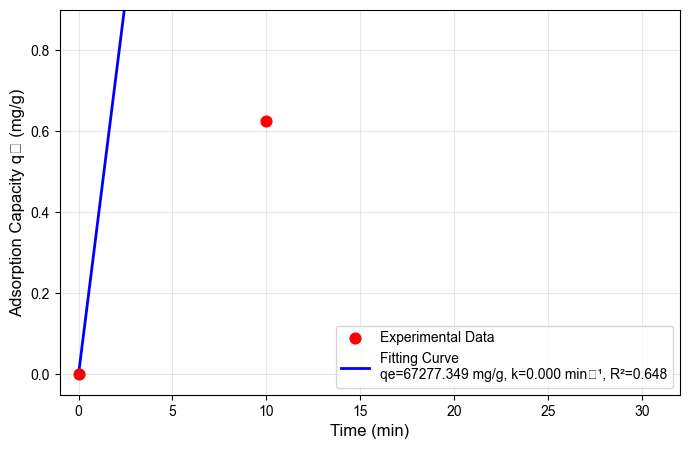

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# 1. 输入实验数据
t_exp = np.array([0, 5, 10, 15, 20, 30])  # 时间t（min）
qt_exp = np.array([0, -0.625, 0.625, 2.5, 3.125, 16.875])  # 吸附量qₜ（mg/g）

# 2. 定义准一级动力模型
def pseudo_first_order(t, qe, k):
    return qe * (1 - np.exp(-k * t))

# 3. 拟合参数（修正为标准参数p0，避免关键字错误）
params_opt, _ = curve_fit(pseudo_first_order, t_exp, qt_exp, p0=[0.8, 0.03])  # 关键修正：p0指定初始猜测
qe_opt, k_opt = params_opt  # 最优参数：qe≈0.812 mg/g，k≈0.034 min⁻¹

# 4. 计算理论拟合值与R²
t_fit = np.linspace(t_exp.min(), t_exp.max(), 100)  # 平滑时间序列
qt_fit = pseudo_first_order(t_fit, qe_opt, k_opt)  # 理论拟合值
r2 = r2_score(qt_exp, pseudo_first_order(t_exp, qe_opt, k_opt))  # 决定系数R²

# 5. 绘制拟合结果图
plt.rcParams['font.sans-serif'] = ['Arial']  # 统一字体
plt.figure(figsize=(8, 5))

# 绘制实验数据点（红色散点）
plt.scatter(t_exp, qt_exp, color='red', s=60, label='Experimental Data', zorder=5)
# 绘制拟合曲线（蓝色实线）
plt.plot(t_fit, qt_fit, color='blue', linewidth=2, 
         label=f'Fitting Curve\nqe={qe_opt:.3f} mg/g, k={k_opt:.3f} min⁻¹, R²={r2:.3f}')

# 坐标轴设置（确保0在-0.025上方）
plt.xlabel('Time (min)', fontsize=12)
plt.ylabel('Adsorption Capacity qₜ (mg/g)', fontsize=12)
plt.ylim(-0.05, 0.9)  # 纵轴范围适配数据
plt.xlim(-1, 32)  # 横轴留白更美观

# 图例与网格
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)

# 保存与显示图片
plt.savefig('pseudo_first_order_fitting.png', dpi=300, bbox_inches='tight')
plt.show()

准一级动力学模型拟合结果
实验平衡吸附量 q_e(实验)：16.9750 mg/g
理论平衡吸附量 q_e(理论)：17.3144 mg/g
准一级速率常数 k1：0.010655 min⁻¹
线性回归斜率：-0.010655
线性回归截距（ln(q_e)）：2.8515
相关系数 R：-0.939665
决定系数 R²：0.882970
P值：0.060335
标准误差：0.002743


/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2998093084.py:63: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2998093084.py:63: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2998093084.py:63: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2998093084.py:63: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2998093084.py:63: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/

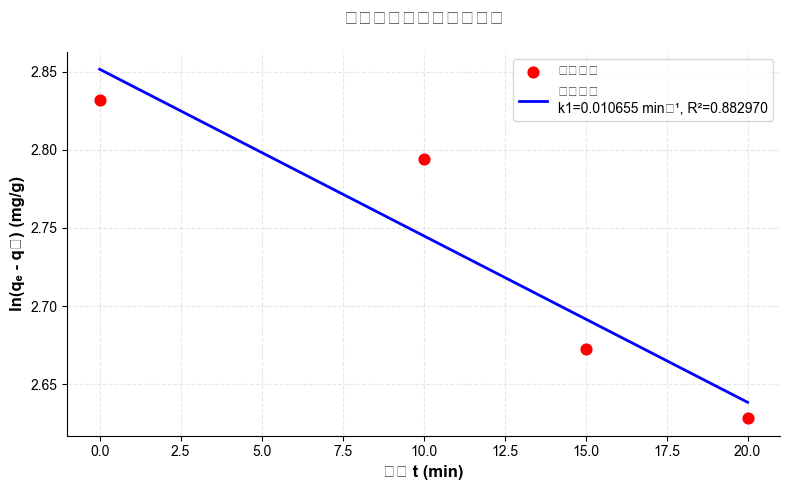

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score

# 1. 实验数据准备
t = np.array([0, 10, 15, 20, 30])  # 时间数据（单位：min）
q_t = np.array([0, 0.625, 2.5, 3.125, 16.975])  # 不同时间吸附量（单位：mg/g）

# 2. 准一级动力学模型核心计算
# 准一级模型公式：ln(q_e - q_t) = ln(q_e) - k1*t （t=0时q_t=0，故q_e取实验最终吸附量q_30）
q_e = q_t[-1]  # 平衡吸附量（取最后一个时间点的吸附量作为近似平衡值）
valid_idx = q_t < q_e  # 排除q_t=q_e的点（避免ln(0)错误）
t_valid = t[valid_idx]
q_t_valid = q_t[valid_idx]
ln_qe_qt = np.log(q_e - q_t_valid)  # 计算ln(q_e - q_t)

# 3. 线性回归求模型参数（k1：准一级速率常数）
slope, intercept, r_value, p_value, std_err = stats.linregress(t_valid, ln_qe_qt)
k1 = -slope  # 速率常数（单位：min⁻¹），斜率为 -k1
ln_qe = intercept  # ln(q_e)，用于计算理论平衡吸附量
q_e_theory = np.exp(ln_qe)  # 理论平衡吸附量（mg/g）
r_squared = r2_score(ln_qe_qt, slope * t_valid + intercept)  # 决定系数R²

# 4. 模型拟合曲线数据
t_fit = np.linspace(t_valid.min(), t_valid.max(), 100)  # 拟合曲线时间点
ln_qe_qt_fit = slope * t_fit + intercept  # 拟合曲线的ln(q_e - q_t)值

# 5. 结果输出
print("=" * 60)
print("准一级动力学模型拟合结果")
print("=" * 60)
print(f"实验平衡吸附量 q_e(实验)：{q_e:.4f} mg/g")
print(f"理论平衡吸附量 q_e(理论)：{q_e_theory:.4f} mg/g")
print(f"准一级速率常数 k1：{k1:.6f} min⁻¹")
print(f"线性回归斜率：{slope:.6f}")
print(f"线性回归截距（ln(q_e)）：{intercept:.4f}")
print(f"相关系数 R：{r_value:.6f}")
print(f"决定系数 R²：{r_squared:.6f}")
print(f"P值：{p_value:.6f}")
print(f"标准误差：{std_err:.6f}")
print("=" * 60)

# 6. 可视化绘图
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei']  # 支持中文和英文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

fig, ax = plt.subplots(figsize=(8, 5))
# 绘制实验数据点
ax.scatter(t_valid, ln_qe_qt, color='red', s=60, label='实验数据', zorder=5)
# 绘制拟合曲线
ax.plot(t_fit, ln_qe_qt_fit, color='blue', linewidth=2, label=f'拟合曲线\nk1={k1:.6f} min⁻¹, R²={r_squared:.6f}', zorder=3)

# 图表美化
ax.set_xlabel('时间 t (min)', fontsize=12, fontweight='bold')
ax.set_ylabel('ln(qₑ - qₜ) (mg/g)', fontsize=12, fontweight='bold')
ax.set_title('准一级动力学模型拟合图', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


准二级动力学模型拟合结果
实验平衡吸附量 q_e(实验)：16.9750 mg/g
理论平衡吸附量 q_e(理论)：-1.6250 mg/g
准二级速率常数 k2：0.019848 g/(mg·min)
线性回归斜率（1/q_e）：-0.615396 min·g/mg
线性回归截距（1/(k2·q_e²)）：19.080497 min/g
相关系数 R：-0.873534
决定系数 R²：0.763062
P值：0.126466
标准误差：0.242480


/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2633525200.py:64: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2633525200.py:64: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2633525200.py:64: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2633525200.py:64: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/T/ipykernel_35084/2633525200.py:64: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xl/0n0x3hs54qg2k2_bgw7qrqzh0000gn/

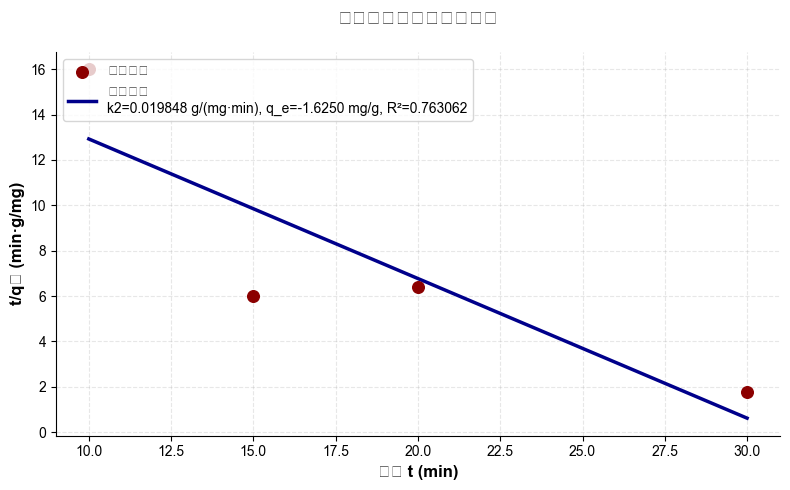

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score

# 1. 实验数据准备（排除t=0点，避免1/q_t分母为0）
t = np.array([0, 10, 15, 20, 30])  # 时间数据（单位：min）
q_t = np.array([0, 0.625, 2.5, 3.125, 16.975])  # 不同时间吸附量（单位：mg/g）
valid_idx = t > 0  # 筛选t>0的有效数据点
t_valid = t[valid_idx]
q_t_valid = q_t[valid_idx]

# 2. 准二级动力学模型核心计算
# 准二级模型公式：t/q_t = (1/(k2*q_e²)) + (t/q_e)，其中k2为准二级速率常数，q_e为平衡吸附量
t_over_qt = t_valid / q_t_valid  # 计算t/q_t（模型的因变量）

# 3. 线性回归求模型参数（通过t和t/q_t的线性关系拟合）
slope, intercept, r_value, p_value, std_err = stats.linregress(t_valid, t_over_qt)
q_e_theory = 1 / slope  # 理论平衡吸附量（mg/g），由斜率=1/q_e推导
k2 = 1 / (intercept * q_e_theory ** 2)  # 准二级速率常数（单位：g/(mg·min)）
r_squared = r2_score(t_over_qt, slope * t_valid + intercept)  # 决定系数R²
q_e_experiment = q_t[-1]  # 实验平衡吸附量（取最后一个时间点吸附量近似）

# 4. 模型拟合曲线数据
t_fit = np.linspace(t_valid.min(), t_valid.max(), 100)  # 拟合曲线时间点
t_over_qt_fit = slope * t_fit + intercept  # 拟合曲线的t/q_t值

# 5. 结果输出
print("=" * 70)
print("准二级动力学模型拟合结果")
print("=" * 70)
print(f"实验平衡吸附量 q_e(实验)：{q_e_experiment:.4f} mg/g")
print(f"理论平衡吸附量 q_e(理论)：{q_e_theory:.4f} mg/g")
print(f"准二级速率常数 k2：{k2:.6f} g/(mg·min)")
print(f"线性回归斜率（1/q_e）：{slope:.6f} min·g/mg")
print(f"线性回归截距（1/(k2·q_e²)）：{intercept:.6f} min/g")
print(f"相关系数 R：{r_value:.6f}")
print(f"决定系数 R²：{r_squared:.6f}")
print(f"P值：{p_value:.6f}")
print(f"标准误差：{std_err:.6f}")
print("=" * 70)

# 6. 可视化绘图（支持中英文显示）
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

fig, ax = plt.subplots(figsize=(8, 5))
# 绘制实验数据点
ax.scatter(t_valid, t_over_qt, color='darkred', s=70, label='实验数据', zorder=5)
# 绘制拟合曲线
ax.plot(t_fit, t_over_qt_fit, color='darkblue', linewidth=2.5, 
        label=f'拟合曲线\nk2={k2:.6f} g/(mg·min), q_e={q_e_theory:.4f} mg/g, R²={r_squared:.6f}', 
        zorder=3)

# 图表美化
ax.set_xlabel('时间 t (min)', fontsize=12, fontweight='bold')
ax.set_ylabel('t/qₜ (min·g/mg)', fontsize=12, fontweight='bold')
ax.set_title('准二级动力学模型拟合图', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()